# Here we perform Direct Randomized Benchmarking (DRB) on a 5 qubit processor

In [17]:
import numpy as np
import pygsti
from matplotlib import pyplot as plt
from pygsti.processors import QubitProcessorSpec as QPS
from pygsti.processors import CliffordCompilationRules as CCR
from qiskit import QuantumCircuit, execute, Aer, transpile
from qiskit_aer.noise import depolarizing_error, NoiseModel
from scipy.optimize import curve_fit
from rb_utils import pygsti_to_qasm, qasm_to_qiskit

# Define  parameters 

In [18]:
# chip parameters

n_qubits = 5

qubit_labels = ['Q0', 'Q1', 'Q2', 'Q3', 'Q4']

gate_names = ['Gxpi2', 'Gxmpi2', 'Gypi2', 'Gympi2', 'Gcnot']

n_avg = 1000

pspec = QPS(n_qubits, gate_names, qubit_labels=qubit_labels, geometry='ring')

compilations = {'absolute': CCR.create_standard(pspec, 'absolute', ('paulis', '1Qcliffords'), verbosity=0),
                'paulieq': CCR.create_standard(pspec, 'paulieq', ('1Qcliffords', 'allcnots'), verbosity=0)}


# Creating DRB sequences

In [19]:
depths = np.arange(1, 300, 20)
num_samples = 3

sampler = 'edgegrab'
samplerargs = [0.25]
citerations = 20

randomizeout = True

design = pygsti.protocols.DirectRBDesign(pspec,
                                         compilations,
                                         depths,
                                         num_samples,
                                         qubit_labels=qubit_labels,
                                         sampler=sampler,
                                         samplerargs=samplerargs,
                                         randomizeout=randomizeout,
                                         citerations=citerations)

circuits = design.all_circuits_needing_data

qasm_circuits = pygsti_to_qasm(circuits)
qiskit_circuits = qasm_to_qiskit(qasm_circuits)

states = np.array(design.idealout_lists).flatten()

- Sampling 3 circuits at DRB length 1 (1 of 15 depths) with seed 309818
- Sampling 3 circuits at DRB length 21 (2 of 15 depths) with seed 309821
- Sampling 3 circuits at DRB length 41 (3 of 15 depths) with seed 309824
- Sampling 3 circuits at DRB length 61 (4 of 15 depths) with seed 309827
- Sampling 3 circuits at DRB length 81 (5 of 15 depths) with seed 309830
- Sampling 3 circuits at DRB length 101 (6 of 15 depths) with seed 309833
- Sampling 3 circuits at DRB length 121 (7 of 15 depths) with seed 309836
- Sampling 3 circuits at DRB length 141 (8 of 15 depths) with seed 309839
- Sampling 3 circuits at DRB length 161 (9 of 15 depths) with seed 309842
- Sampling 3 circuits at DRB length 181 (10 of 15 depths) with seed 309845
- Sampling 3 circuits at DRB length 201 (11 of 15 depths) with seed 309848
- Sampling 3 circuits at DRB length 221 (12 of 15 depths) with seed 309851
- Sampling 3 circuits at DRB length 241 (13 of 15 depths) with seed 309854
- Sampling 3 circuits at DRB length 261 

# Run simulation

we take the 1 qubit gate depolarizing error to be 0.001 and 2 qubit error 0.01 (one order of magnitude lower).

In [20]:
simulator = Aer.get_backend('aer_simulator')

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01  # 2-qubit gate

error_1 = depolarizing_error(prob_1, 1)
error_2 = depolarizing_error(prob_2, 2)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['x', 'rx', 'rz', 'u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# transpile circuits
circs = transpile(qiskit_circuits, simulator, basis_gates=["id", "sx", "x", "rz", "cx"])

# Run and get counts
results = simulator.run(circs, noise_model=noise_model, shots=n_avg).result()


def get_probabilities(results, states):
    counts = results.get_counts()
    probabilities = []

    for i, count in enumerate(counts):
        state = states[i][::-1]
        prop = count.get(state)
        if not prop:
            prop = 0

        probabilities.append(prop / n_avg)

    return np.reshape(probabilities, (len(depths), num_samples))


probabilities = get_probabilities(results, states)

mean_probabilities = np.mean(probabilities, axis=1)

# Plots

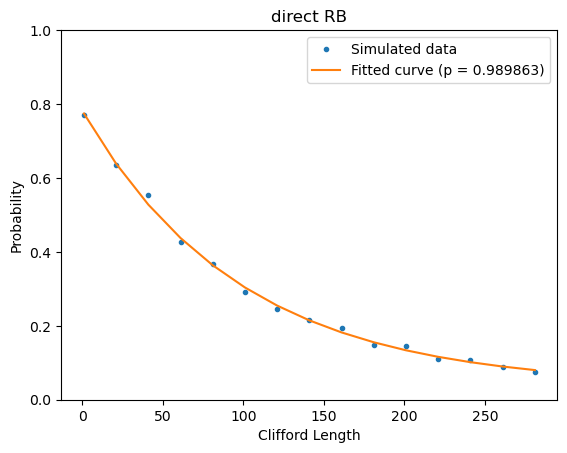

In [21]:
def decay_model(m, A, B, p):
    return A * p ** (m - 1) + B


args = curve_fit(decay_model, depths, mean_probabilities, p0=[0.5, 0.5, 0.9])
plt.plot(depths, mean_probabilities, '.', label='Simulated data')
plt.plot(depths, decay_model(depths, *args[0]), label=f'Fitted curve (p = {args[0][2]:3f})')
plt.ylim([0, 1])
plt.title('direct RB')
plt.xlabel('Clifford Length')
plt.ylabel('Probability')
plt.legend()
plt.show()



# What is the error rate?

The fit parameters, are distribution depended (how many 2 qubit gate are inside the layers), and do not provide any information about the error rate at this point. However,

if we repeat the experiment with different distribution we will find the true error rate of 1 and 2 qubit native gates.

# New experiemnt with probablity of 0.25 to have cnot in each layer:

In [22]:
new_samplerargs = [0.75]
design = pygsti.protocols.DirectRBDesign(pspec, compilations, depths, num_samples, qubit_labels=qubit_labels,
                                         sampler=sampler,
                                         samplerargs=new_samplerargs, randomizeout=randomizeout,
                                         citerations=citerations)

circuits = design.all_circuits_needing_data

qasm_circuits = pygsti_to_qasm(circuits)
qiskit_circuits = qasm_to_qiskit(qasm_circuits)

states = np.array(design.idealout_lists).flatten()
circs = transpile(qiskit_circuits, simulator, basis_gates=["id", "sx", "x", "rz", "cx"])

results = simulator.run(circs, noise_model=noise_model, shots=n_avg).result()




- Sampling 3 circuits at DRB length 1 (1 of 15 depths) with seed 489399
- Sampling 3 circuits at DRB length 21 (2 of 15 depths) with seed 489402
- Sampling 3 circuits at DRB length 41 (3 of 15 depths) with seed 489405
- Sampling 3 circuits at DRB length 61 (4 of 15 depths) with seed 489408
- Sampling 3 circuits at DRB length 81 (5 of 15 depths) with seed 489411
- Sampling 3 circuits at DRB length 101 (6 of 15 depths) with seed 489414
- Sampling 3 circuits at DRB length 121 (7 of 15 depths) with seed 489417
- Sampling 3 circuits at DRB length 141 (8 of 15 depths) with seed 489420
- Sampling 3 circuits at DRB length 161 (9 of 15 depths) with seed 489423
- Sampling 3 circuits at DRB length 181 (10 of 15 depths) with seed 489426
- Sampling 3 circuits at DRB length 201 (11 of 15 depths) with seed 489429
- Sampling 3 circuits at DRB length 221 (12 of 15 depths) with seed 489432
- Sampling 3 circuits at DRB length 241 (13 of 15 depths) with seed 489435
- Sampling 3 circuits at DRB length 261 

# Plotting both of the together

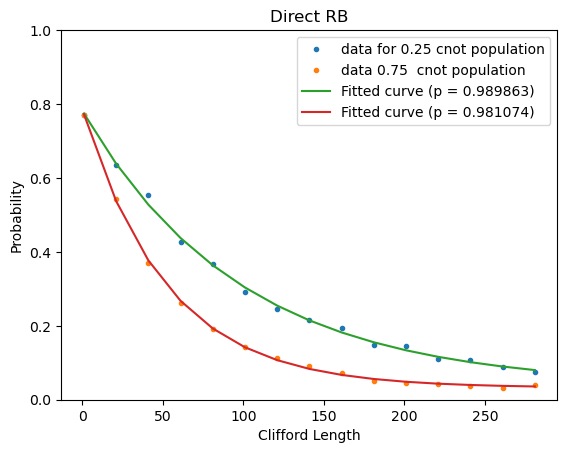

In [23]:
new_probabilities = get_probabilities(results, states)
new_mean_probabilities = np.mean(new_probabilities, axis=1)
new_args = curve_fit(decay_model, depths, new_mean_probabilities, p0=[0.5, 0.5, 0.9])

plt.plot(depths, mean_probabilities, '.', label='data for 0.25 cnot population')
plt.plot(depths, new_mean_probabilities, '.', label='data 0.75  cnot population ')

plt.plot(depths, decay_model(depths, *args[0]), label=f'Fitted curve (p = {args[0][2]:3f})')
plt.plot(depths, decay_model(depths, *new_args[0]), label=f'Fitted curve (p = {new_args[0][2]:3f})')

plt.ylim([0, 1])
plt.title('Direct RB')
plt.xlabel('Clifford Length')
plt.ylabel('Probability')
plt.legend()
plt.show()




The true errors can be extracted by solving a linear system of equations of the errors

$ r_1 = 0.75*r_{1q} + 0.25*r_{2q}$\
$ r_2 = 0.25*r_{1q} + 0.75*r_{2q}$

where 

$ r_1 $ = total error from experiment with probability of 0.25 to have 2 qubit gate in layer\
$ r_2 $ = total error from experiment with probability of 0.75 to have 2 qubit gate in layer\


single qubit depolarization = $ d*(r_1)/(d-1) / 5$ \
single qubit depolarization = $ d*(r_1)/(d-1) / 2$ 



In [24]:
d = 2 ** n_qubits

r1 = (d - 1) / d * (1 - args[0][2])
r2 = (d - 1) / d * (1 - new_args[0][2])

a = np.array([[0.75, 0.25], [0.25, 0.75]])
b = np.array([r1, r2])

r_1g, r_2g = np.linalg.solve(a, b)

d1 = r_1g * d / (d - 1) / n_qubits
d2 = r_2g * d / (d - 1) / 2 - d1

print(f'One qubit gate error = {r_1g} ')
print(f'Two qubit gate error = {r_2g}\n ')

print(f'One qubit gate depolrization = {d1} should be {prob_1}')
print(f'Two qubit gate depolrization  = {d2} shold be {prob_2}')


One qubit gate error = 0.005562536773613929 
Two qubit gate error = 0.022591993385976925
 
One qubit gate depolrization = 0.0011483946887461014 should be 0.001
Two qubit gate depolrization  = 0.010511988994338764 shold be 0.01
